In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sksurv.preprocessing import OneHotEncoder as SurvOneHotEncoder
from sksurv.util import Surv

from sksurv.column import encode_categorical
from sksurv.column import standardize
from sksurv.util import Surv

from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxnetSurvivalAnalysis

from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

def evaluate_model_uno_c(model, test_X, test_y, train_y, times):
    pred = model.predict(test_X)
    uno_concordance = concordance_index_ipcw(train_y, test_y, pred, tau=times[-1])
    return uno_concordance

In [2]:
# pickle_file = 'data/COX_DATA_FULL_LIVING.pkl'
pickle_file = '../data/COX_DATA_FULL_LIVING_EXPERIMENTAL.pkl'

with open(pickle_file, 'rb') as f:
    dataset = pickle.load(f)

dataset.drop(['DIAG_KI', 'COD_KI'], axis=1, inplace=True)

In [3]:
yes_categorical=[
                "PRE_TX_TXFUS", 
                "GENDER",
                "ON_DIALYSIS", 
                "ETHCAT", 
                "ETHCAT_DON",
                'DIAB',
                'HCV_SEROSTATUS',  
                'LIV_DON_TY',
                "ABO_MAT", 
                'HBV_CORE', 
                
            ]
yes_numerical = [   
                # "SERUM_CREAT", # might be data leakage, as it is after the transplant
                "AGE", 
                "AGE_DON",
                "DIALYSIS_TIME",                
                "KI_CREAT_PREOP", # negative importance
                "NPKID", # negative importance
                "HGT_CM_CALC",  # negative importance
                "BMI_DON_CALC", # negative importance
                ]

In [4]:
dataset.dropna(subset=yes_numerical+yes_categorical, inplace=True)

In [5]:
dataset.shape

(53082, 58)

In [6]:
numeric_features = [x for x in yes_numerical if x != "PTIME" and x != "PSTATUS"]

categorical_x = encode_categorical(dataset[yes_categorical])
numerical_x = standardize(dataset[yes_numerical])
X = pd.concat([numerical_x, categorical_x], axis=1)

survival_time = dataset["PTIME"].astype(np.float64)
event = dataset["PSTATUS"].astype(float).astype(bool)

y = Surv.from_arrays(event, survival_time, "Status", "Days")

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y["Status"], random_state=42)

In [39]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

# est = GradientBoostingSurvivalAnalysis(n_estimators=3, learning_rate=1)
# est.fit(X_train, y_train)
# est.score(X_test, y_test)

In [8]:
import pickle

lower, upper = np.percentile(y["Days"], [10, 90])
times = np.arange(lower, upper + 1)

with open('../TrainedModels/GBSA_0.722_lr0.2_leaving_early_stopping.pkl', 'rb') as file:
    best_model = pickle.load(file)

In [9]:
from sklearn.inspection import permutation_importance

# uncoment if you want to calculate permutation importance (data must not be processed by pipeline)
# result = permutation_importance(est, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1)
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1)

In [10]:
pd.set_option('display.max_rows', None)

# columns = numeric_features + categorical_features

importances_df = pd.DataFrame(result.importances_mean, index=X_train.columns)
importances_df.columns = ['Importance']
importances_df.sort_values(by='Importance', ascending=False, inplace=True)

# Print out feature importances
print(importances_df)

                   Importance
ON_DIALYSIS=Y        0.027521
DIAB=5.0             0.019476
LIV_DON_TY=4.0       0.013106
DIALYSIS_TIME        0.009811
DIAB=3.0             0.007325
LIV_DON_TY=2.0       0.005390
DIAB=2.0             0.003791
ETHCAT_DON=2.0       0.003636
ETHCAT=5             0.003147
ETHCAT=4             0.002992
ABO_MAT=2.0          0.002541
LIV_DON_TY=10.0      0.001930
HBV_CORE=P           0.001091
LIV_DON_TY=9.0       0.001022
ETHCAT=2             0.000788
DIAB=998.0           0.000658
LIV_DON_TY=6.0       0.000621
LIV_DON_TY=999.0     0.000553
DIAB=4.0             0.000500
ETHCAT_DON=5.0       0.000376
ETHCAT_DON=6.0       0.000304
ETHCAT=6             0.000275
ETHCAT_DON=7.0       0.000202
HBV_CORE=ND          0.000200
LIV_DON_TY=3.0       0.000162
LIV_DON_TY=5.0       0.000079
LIV_DON_TY=11.0      0.000050
ABO_MAT=3.0          0.000024
NPKID                0.000022
HGT_CM_CALC          0.000000
LIV_DON_TY=8.0       0.000000
BMI_DON_CALC         0.000000
LIV_DON_TY

In [ ]:
plt_importances = importances_df.sort_values(by='Importance', ascending=True)
plt_importances['Importance']=plt_importances['Importance'].astype(float)
path = "../Thesis/Images/Results/"


diab = ["DIAB=3.0", "DIAB=5.0", "DIAB=2.0", "DIAB=4.0", "DIAB=998.0"]
eth = ["ETHCAT=2", "ETHCAT=5", "ETHCAT=4", "ETHCAT=9", "ETHCAT=6", "ETHCAT=7"]
eth_don = ["ETHCAT_DON=2.0", "ETHCAT_DON=5.0", "ETHCAT_DON=4.0", "ETHCAT_DON=9.0", "ETHCAT_DON=6.0", "ETHCAT_DON=7.0"]
liv_don_ty = ["LIV_DON_TY=6.0", "LIV_DON_TY=9.0", "LIV_DON_TY=11.0", "LIV_DON_TY=8.0", "LIV_DON_TY=5.0", "LIV_DON_TY=2.0", "LIV_DON_TY=12.0", "LIV_DON_TY=3.0", "LIV_DON_TY=10.0", "LIV_DON_TY=7.0", "LIV_DON_TY=999.0", "LIV_DON_TY=4.0"]
abo = ["ABO_MAT=2.0", "ABO_MAT=3.0"]
hcv = ["HCV_SEROSTATUS=ND", "HCV_SEROSTATUS=P"]
hbv = ["HBV_CORE=P", "HBV_CORE=ND"]


plt_importances.loc["DIAB", 'Importance'] = plt_importances.loc[diab, 'Importance'].sum()
plt_importances.loc["ETHCAT", 'Importance'] = plt_importances.loc[eth, 'Importance'].sum()
plt_importances.loc["ETHCAT_DON", 'Importance'] = plt_importances.loc[eth_don, 'Importance'].sum()
plt_importances.loc["LIV_DON_TY", 'Importance'] = plt_importances.loc[liv_don_ty, 'Importance'].sum()
plt_importances.loc["ABO_MAT", 'Importance'] = plt_importances.loc[abo, 'Importance'].sum()
plt_importances.loc["HCV_SEROSTATUS", 'Importance'] = plt_importances.loc[hcv, 'Importance'].sum()
# plt_importances.loc["HBV_CORE", 'Importance'] = plt_importances.loc[hbv, 'Importance'].sum()

plt_importances.drop(diab, inplace=True)
plt_importances.drop(eth, inplace=True)
plt_importances.drop(eth_don, inplace=True)
plt_importances.drop(liv_don_ty, inplace=True)
plt_importances.drop(abo, inplace=True)
plt_importances.drop(hcv, inplace=True)
plt_importances.drop(hbv, inplace=True)
# plt_importances.sort_values(by='Importance', ascending=True, inplace=True)

plt_importances.sort_values(by='Importance', ascending=True, inplace=True)

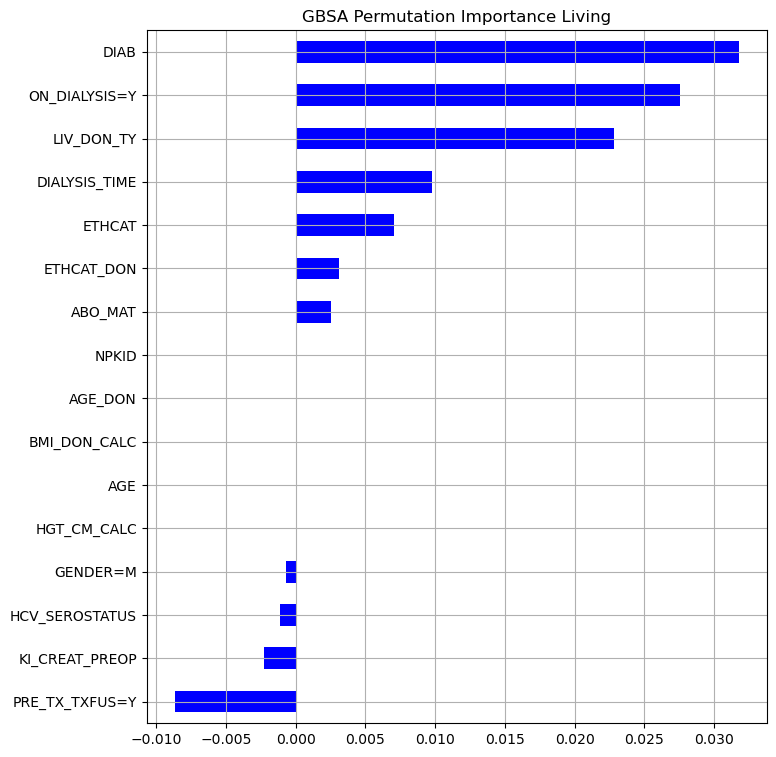

In [15]:
plt_importances.plot.barh(color='blue', legend=False, title='GBSA Permutation Importance Living', grid=True, figsize=(8, 9))
path = "../../Thesis/Images/Results/"
plt.savefig(path + "GBSA_FI_living.pdf", bbox_inches="tight")